# <font color="lightgreen">**Final Project: Comparison of PPO and SAC on Bipedal Walker Task**</font>
#### **Created by 65340500058 Anuwit Intet**

## <font color="pink">**Objectives:**</font>

1. To study advanced techniques in Deep Reinforcement Learning from academic articles

2. To apply those techniques in your simulation

3. To have fun!!!

## <font color="pink">**Part 1: Project Overview**</font>

### <font color="yellow">**Scope**</font>

1. This project compares 2 Actor-Critic algorithms that receive continuous observations and send actions as continuous Action Space: Proximal Policy Optimization and Soft Actor-Critic. 

2. Compare in the context of the BipedalWalker-v3 Task of the gymnasium, which is a task where the agent moves with 2 legs, where the action is the torque of each joint that is continuous.

3. The comparison of these two algorithms will be done in terms of learning efficiency and deployment performance.

4. Study the comparison of these two algorithms using the ready-made code of stable-baseline3.

5. Focus only on the comparison of the two algorithms, not on the optimization of each algorithm's hyperparameter.

### <font color="yellow">**BipedalWalker-v3**</font>

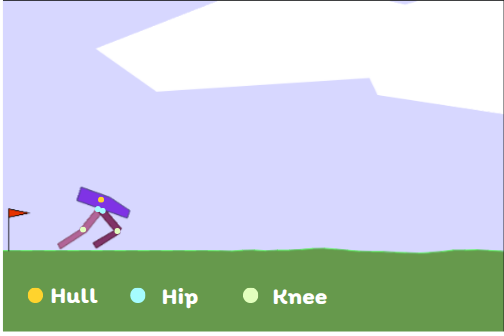

**BipedalWalker-v3** is the environment from gym. It is 2 legs with the hull. The goal is to stabilize and walk as far as it can to get the reward.

- **Action Space**

    - motor speed values in the [-1, 1] range for each of the 4 joints at both hips and knees.

- **Observation Space**

    - Hull angle, angular velocity, horizontal speed, vertical speed **4 variables**

    - position of joints and joints angular speed **8 variables**

    - legs contact with ground **2 variables**

    - 10 LIDAR rangefinder measurements. **10 variables**

- **Reward Setting**

    - Reward is given for moving forward.

    - totaling 300+ points up to the far end. 

    - If the robot falls, it gets -100. 

    - Applying motor torque costs a small amount of points.

## <font color="pink">**Part 2: Background Knowledge**</font>

### <font color="yellow">**Proximal Policy Optimization**</font>

**Proximal Policy Optimization (PPO)** is a very popular **on-policy** algorithm in the Policy Gradient family due to its balance between training stability and sample efficiency.

#### **Principle**

The PPO updates the policy using data from the old policy while **limiting updates** to prevent changes from occurring too quickly using **Clipped Surrogate Objective** as follows:

$$
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t,\ \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]
$$

where:
- $ r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)} $ is **probability ratio**
- $ \hat{A}_t $ is **Advantage estimate**
- $ \epsilon $ is **clipping parameter** (Ex. 0.1 - 0.3)

The PPO will update policy when collect trajectory in amount of batch size. It will not use the replay buffer at all.

#### **Advantage (GAE) Calculation**

PPO uses **Generalized Advantage Estimation (GAE)** to calculate advantage, which reduces variance:

$$
\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
$$
$$
\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots
$$

Or in recursive form:

$$
\hat{A}_t = \delta_t + \gamma \lambda \hat{A}_{t+1}
$$

Where:
- $ \gamma $: discount factor  
- $ \lambda $: GAE smoothing factor (Between 0 to 1)

#### **Critic Loss**

Critic is trained to approximate the value function $ V(s_t) $ using Mean Squared Error:

$$
L_V = \frac{1}{2} \left( V_\psi(s_t) - \hat{R}_t \right)^2
$$

where $ \hat{R}_t $ is the return estimate (i.e. GAE + baseline)

#### **Entropy Bonus**

PPO increases entropy to promote exploration:

$$
L_{entropy} = \mathbb{E}_t [\mathcal{H}(\pi(\cdot | s_t))]
$$

#### **Total Loss**

PPO tries to minimize the loss function as follows:

$$
L = -L^{CLIP}(\theta) + c_1 L_V - c_2 L_{entropy}
$$

Where:
- $c_1$: the weight of the critic loss (e.g. 0.5)
- $c_2$: the weight of the entropy bonus (e.g. 0.01)

#### **Advantages of PPO**

- No need for replay buffer (on-policy)

- Stable update stability (via clipping)

- Easy to use and robust to hyperparameters

#### **Limitations**

- Lower sample efficiency than off-policy methods (e.g. SAC, TD3)

- Not suitable for tasks that require repeated learning

### <font color="yellow">**Soft Actor-Critic**</font>

**Soft Actor-Critic (SAC)** is an **off-policy actor-critic** algorithm for continuous action space that balances between maximizing reward and maximizing entropy (exploration).

#### **Principle**

SAC seeks a policy that maximizes both expected return and entropy:

$$
\pi^* = \arg\max_\pi \sum_{t} \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} \left[ r(s_t, a_t) + \alpha \mathcal{H}(\pi(\cdot | s_t)) \right]
$$

**Where:**

- $ s_t $: state at time $ t $

- $ a_t $: action at time $ t $

- $ r(s_t, a_t) $: reward for doing $ a_t $ in $ s_t $

- $ \rho_\pi $: distribution of trajectories under policy $ \pi $

- $ \mathcal{H}(\pi(\cdot | s_t)) $: entropy of policy

- $ \alpha $: entropy coefficient (controls the weight of entropy)

The SAC will update parameter every the amount of steps that was set.

#### **Q-function Loss (Critic Loss)**

$$
J_Q(\theta_i) = \mathbb{E}_{(s_t, a_t) \sim \mathcal{D}} \left[ \frac{1}{2} \left( Q_{\theta_i}(s_t, a_t) - \hat{Q}(s_t, a_t) \right)^2 \right]
$$

$$
\hat{Q}(s_t, a_t) = r_t + \gamma (1 - d_t) \left[ \min_{j=1,2} Q_{\bar{\theta}_j}(s_{t+1}, a_{t+1}) - \alpha \log \pi(a_{t+1}|s_{t+1}) \right]
$$

**Where:**

- $ \theta_i $: Q-network parameter of $i$ (SAC has 2)

- $ \bar{\theta}_j $: target Q-network parameter

- $ \mathcal{D} $: replay buffer

- $ \gamma $: discount factor

- $ d_t $: done flag (1 if terminate)

- $ \pi(a_{t+1}|s_{t+1}) $: policy distribution

- $ \alpha $: entropy coefficient

#### **Policy Loss (Actor Loss)**

$$
J_\pi(\phi) = \mathbb{E}_{s_t \sim \mathcal{D}} \left[ \mathbb{E}_{a_t \sim \pi_\phi} \left[ \alpha \log \pi_\phi(a_t|s_t) - Q_{\theta}(s_t, a_t) \right] \right]
$$

**Where:**

- $ \phi $: policy parameters

- $ Q_\theta(s_t, a_t) $: Q-network estimated values

- $ \log \pi_\phi(a_t|s_t) $: log-probability of the selected action


#### **Entropy Coefficient Loss (อัปเดตค่า $ \alpha $)**

$$
J(\alpha) = \mathbb{E}_{a_t \sim \pi} \left[ -\alpha \left( \log \pi(a_t | s_t) + \mathcal{H}_{\text{target}} \right) \right]
$$

**Where:**

- $ \mathcal{H}_{\text{target}} $: Target entropy (e.g. $-|A|$, if $A$ is the action dimension)

- Use this loss to let the agent adjust the entropy exploration level itself (automatic entropy tuning)

#### **Parameter Updates**

1. **Critic update:** Apply TD error with Double Q-learning

2. **Actor update:** Reduce loss according to soft policy gradient

3. **Entropy update:** Adjust $ \alpha $ by optimizing entropy objective

4. **Target Q update:** Polyak averaging

$$
\bar{\theta} \leftarrow \tau \theta + (1 - \tau) \bar{\theta}
$$

#### **Advantages**

- Sample-efficient (off-policy)

- Robust to stochasticity

- Reduce overestimation bias with Double Q

- Adaptive exploration

#### **Limitations**

- Higher training complexity than PPO

- Sensitive to entropy tuning if not using auto


### <font color="yellow">**Hypothesis Testing**</font>

Hypothesis testing steps

**1. Set hypotheses ($H_0$ and $H_1$)**

- **$H_0$ (Null Hypothesis):** Initial hypothesis, such as there is no difference between two groups

- **$H_1$ (Alternative Hypothesis):** Opposite hypothesis, such as there is a difference or one group is better than the other

**2. Set the significance level ($\alpha$)**

- Value used to decide whether to reject $H_0$ or not

- Generally, $\alpha = 0.05$ is used

**3. Select the appropriate test statistic.**

- **Two-group means (n ​​< 30):** Use **t-test**

- **Two-group means (n ​​≥ 30):** Use **z-test**

- **Two-group proportions:** Use **z-test for proportions**

- **Variance:** Use **F-test**

**4. Calculate the test statistic.**

- For example, t-test:
$$
t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

**5. Calculate the $p$-value**

- It is the probability of getting the observed result (or more) if $H_0$ is true

- The lower the $p$, the more likely it is that $H_0$ is false

**6. Compare with the significance level**

- If $p$-value $< \alpha$ → **Reject $H_0$**

- If $p$-value $\geq \alpha$ → **Accept $H_0$**

**7. Summarize the test results**

- Describe the results statistically (e.g., "There is a significant difference")

- Describe the results practically (e.g., "SAC performs better than PPO")


### <font color="yellow">**Fourier Transform**</font>

**Fourier Transform (FT)** is a process that converts data from the **time domain** to the **frequency domain**. It shows how many frequencies a signal contains. Fourier Transform is often used to analyze signals such as EEG vibrations or detect hidden patterns in data.

**Key Idea** "Any signal that is not a sine wave can be written as the sum of many sine waves."

**Discrete Fourier Transform (DFT)**

In computer science, **DFT** is commonly used because the data is limited.

$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-j \frac{2\pi}{N} kn}
$$

- $x_n$ is the input data (time domain) 

- $X_k$ is the frequency spectrum value 

- It is used with $N$ points of data 

Therefore, there is an algorithm called **Fast Fourier Transform (FFT)** that calculates DFT very efficiently and very fast.



### <font color="yellow">**Spectral Flatness**</font>

**Spectral Flatness (SF)** is a measure of how much energy is distributed across different frequencies in a signal, or simply put, how flat the signal spectrum is or whether it has some pronounced peaks. It is widely used in audio, EEG, and agent behavior analysis.

**Intuition meaning**

- If **SF → near 0** → The spectrum has a prominent peak (e.g. sine wave)

- If **SF → near 1** → The spectrum is flat (e.g. noise, or random wave)

**Mathematical Definition**

Let $P_i$ be the Power Spectral Density (PSD) of each frequency $i$.
$$
\text{Spectral Flatness} = \frac{\left( \prod_{i=1}^{N} P_i \right)^{1/N}}{\frac{1}{N} \sum_{i=1}^{N} P_i}
$$

- $\prod$ = the geometric mean
- $\sum$ = the arithmetic mean

## <font color="pink">**Part 3: Assumption and Hypothesis**</font>

### <font color="yellow">**Assumption**</font>

1. PPO algorithm uses conservative policy updates via a clipped objective function, which provides stable learning but slow convergence.

2. SAC algorithm adds an entropy term to increase the chance of random exploration, resulting in a variety of policies but potentially causing the agent to move erratically or unstable.

3. If the agent walks in a regular rhythm, you should see a clear pattern of joint position graphs. If there is no pattern, it may indicate poor control.

### <font color="yellow">**Hypothesis**</font>

1. **PPO updates policy to the best value slower than SAC**

    - **Testing approach**: Observe the trend of rewards of each algorithm visually

    - **$H_0$**: $\text{step}_{\text{best}}^{\text{PPO}} = \text{step}_{\text{best}}^{\text{SAC}}$

    - **$H_1$**: $\text{step}_{\text{best}}^{\text{PPO}} > \text{step}_{\text{best}}^{\text{SAC}}$

2. **SAC receives more rewards than PPO after some learning**

    - **Testing approach**: Use the average reward of the last 20,000 steps

    - **$H_0$**: $\mu_{\text{reward}}^{\text{PPO}} = \mu_{\text{reward}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{reward}}^{\text{PPO}} < \mu_{\text{reward}}^{\text{SAC}}$

3. **PPO makes the agent move more steadily than SAC**

    - **Testing approach**: Use the average of Spectral Flatness

    - **$H_0$**: $\mu_{\text{SF}}^{\text{PPO}} = \mu_{\text{SF}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{SF}}^{\text{PPO}} < \mu_{\text{SF}}^{\text{SAC}}$

4. SAC finds more ways to move than PPO

    - **Testing approach** Compare the Pairwise Action Mean Square Error values ​​between different models in each possible state of both algorithms.

    - **$H_0$**: $\mu_{\text{MSE}}^{\text{PPO}} = \mu_{\text{MSE}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{MSE}}^{\text{PPO}} < \mu_{\text{MSE}}^{\text{SAC}}$

5. **SAC reaches success points more often than PPO**

    - **Testing approach**: Compare the success rates of both algorithms

    - **$H_0$**: $p_{\text{PPO}} = p_{\text{SAC}}$

    - **$H_1$**: $p_{\text{PPO}} < p_{\text{SAC}}$

6. **SAC has better robustness than PPO on new environment**

    - **Testing approach**: Use average reward on new environment

    - **$H_0$**: $\mu_{\text{Reward,new}}^{\text{PPO}} = \mu_{\text{Reward,new}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{Reward,new}}^{\text{PPO}} < \mu_{\text{Reward,new}}^{\text{SAC}}$

7. **PPO has higher reward variance than SAC**

    - **Testing approach**: Compare the mean of reward variance from multiple seed models

    - **$H_0$**: $\mu_{\text{Reward,Variance}}^{\text{PPO}} = \mu_{\text{Reward,Variance}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{Reward,Variance}}^{\text{PPO}} > \mu_{\text{Reward,Variance}}^{\text{SAC}}$

## <font color="pink">**Part 4: Experiment Setup**</font>

In [14]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.logger import configure
import gymnasium as gym
from datetime import datetime
import os
import gc
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from torch.utils.tensorboard import SummaryWriter

### <font color="yellow">**Training Loop**</font>

In [ ]:
def train_rl_agent(algo_name="Algo", seeds=[0], total_timesteps=500_000,
                   log_root="logs/sb3/Project", env_id="BipedalWalker-v3"):
    """
    Train RL agents with different seeds using specified algorithm class.

    Args:
        AlgoClass: Class of RL algorithm (e.g., PPO, SAC, TD3)
        algo_name: Name prefix for log folder
        seeds: List of seed integers
        total_timesteps: Total timesteps per agent
        log_root: Root path for logs
        env_id: Gym environment ID
    """
    run_info = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_root_path = os.path.abspath(log_root)
    os.makedirs(log_root_path, exist_ok=True)
    log_dirs = []

    for seed in seeds:
        log_dir = os.path.join(log_root_path, f"{algo_name}_{run_info}_seed{seed}")
        print(f"\n[INFO] Running {algo_name} with seed={seed}, log_dir={log_dir}")
        os.makedirs(log_dir, exist_ok=True)
        log_dirs.append(log_dir)

        # Create environment
        env = gym.make(env_id, render_mode="rgb_array")

        # Create agent

        if algo_name == "PPO":
            agent = PPO("MlpPolicy", 
                        env,
                        learning_rate=3e-4,
                        n_steps=2048,
                        batch_size=128,
                        n_epochs=10,
                        gamma=0.99,
                        gae_lambda=0.95,
                        clip_range=0.2,
                        ent_coef=0.0,
                        vf_coef=0.5,
                        max_grad_norm=0.5,
                        seed=seed,
                        verbose=1)
            
        elif algo_name == "SAC":
            agent = SAC("MlpPolicy",
                        env,
                        learning_rate=3e-4,           
                        buffer_size=100000,         
                        batch_size=256,              
                        tau=0.005,                   
                        gamma=0.99,                  
                        train_freq=1,                
                        gradient_steps=1,            
                        ent_coef="auto_0.1",         
                        learning_starts=1000,        
                        use_sde=True,                
                        sde_sample_freq=4,          
                        seed=seed,
                        verbose=1)

        # Configure logger
        new_logger = configure(log_dir, ["stdout", "tensorboard"])
        agent.set_logger(new_logger)

        # Callback
        checkpoint_callback = CheckpointCallback(
            save_freq=10000,
            save_path=log_dir,
            name_prefix="model",
            verbose=1
        )

        # Train
        agent.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)

        # Save model
        agent.save(os.path.join(log_dir, "model"))

        # Cleanup
        del agent, env
        gc.collect()

    return log_dirs

Use `tensorboard --logdir logs/sb3/Project/` to see the log

In [8]:
# รัน PPO
PPO_log_dirs = train_rl_agent(algo_name="PPO", seeds=[0, 1, 2, 3, 4])


[INFO] Running PPO with seed=0, log_dir=/home/talae/DRL_NewProject/logs/sb3/Project/PPO_2025-05-22_08-29-09_seed0
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /home/talae/DRL_NewProject/logs/sb3/Project/PPO_2025-05-22_08-29-09_seed0


/home/talae/miniconda3/envs/gymnasium/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:152: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 616      |
|    ep_rew_mean     | -107     |
| time/              |          |
|    fps             | 2359     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 862          |
|    ep_rew_mean          | -112         |
| time/                   |              |
|    fps                  | 2066         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0064466023 |
|    clip_fraction        | 0.0401       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | 0.0135       |
|    learning_r

In [ ]:
# รัน SAC
SAC_log_dirs = train_rl_agent(algo_name="SAC", seeds=[0, 1, 2, 3, 4]) 


[INFO] Running SAC with seed=0, log_dir=/home/talae/DRL_NewProject/logs/sb3/Project/SAC_2025-05-22_08-54-48_seed0
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /home/talae/DRL_NewProject/logs/sb3/Project/SAC_2025-05-22_08-54-48_seed0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 70.8     |
|    ep_rew_mean     | -110     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2525     |
|    time_elapsed    | 0        |
|    total_timesteps | 283      |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 380      |
|    ep_rew_mean     | -133     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 320      |
|    time_elapsed    | 9        |
|    total_timesteps | 30

### <font color="yellow">**Play Agent**</font>

#### <font color="lightblue">**Import Library**</font>

In [89]:
import os
import numpy as np
import pickle
import gymnasium as gym
from scipy.stats import sem, t, gmean, norm
from scipy.signal import welch
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
import pandas as pd
import torch
from collections import defaultdict
from torch.distributions import Normal

#### <font color="lightblue">**Configulation**</font>

In [90]:
# === CONFIGURATION ===
ENV_ID = "BipedalWalker-v3"
RENDER_MODE = "rgb_array"
EPISODES_PER_MODEL = 20
FIXED_SEED = 123
SUCCESS_THRESHOLD = 100
OBS_INDICES = [4, 6, 9, 11]
OBS_TITLES = ["HIP1", "KNEE1", "HIP2", "KNEE2"]

#### <font color="lightblue">**Spectral Flatness Calculation**</font>

In [91]:
def compute_spectral_flatness(signal, sf=1.0):
    freqs, psd = welch(signal, sf, nperseg=min(256, len(signal)))
    flatness = gmean(psd + 1e-12) / (np.mean(psd) + 1e-12)
    return flatness

#### <font color="lightblue">**Evaluate Model**</font>

In [92]:
# calculate confidence interval 95 percent
def ci95(x):
    return sem(x) * t.ppf((1 + 0.95) / 2, len(x) - 1)

In [93]:
# Collect data in 20 test environment
def evaluate_models(log_root_path, model_names, prefix="PPO"):
    env = DummyVecEnv([lambda: gym.make(ENV_ID, render_mode=None)])
    episode_data = []

    for model_idx, model_name in enumerate(model_names):

        # Load Model
        print(f"\n[INFO] Evaluating model: {model_name}")
        if prefix == "PPO":
            model = PPO.load(os.path.join(log_root_path, model_name, "model"), env=env)
        elif prefix == "SAC":
            model = SAC.load(os.path.join(log_root_path, model_name, "model"), env=env)

        # Collect Trajectory
        for ep in range(EPISODES_PER_MODEL):
            seed = FIXED_SEED + ep
            env.envs[0].reset(seed=seed)
            obs = env.reset()
            done = False
            total_reward = 0
            step_count = 0
            obs_history = []

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, _ = env.step(action)
                total_reward += reward[0]
                step_count += 1
                obs_history.append(obs[0])

            obs_history = np.array(obs_history)
            selected_obs = obs_history[:, OBS_INDICES]
            flatness = np.mean([compute_spectral_flatness(selected_obs[:, i]) for i in range(4)])

            print("Episode: ",ep, "Reward: ", total_reward)
            
            episode_data.append({
                "model_name": model_name,
                "model_idx": model_idx,
                "episode": ep,
                "seed": seed,
                "reward": total_reward,
                "steps": step_count,
                "success": total_reward >= SUCCESS_THRESHOLD,
                "obs": selected_obs,
                "entropy": flatness
            })

    return episode_data

In [94]:
# Summarize Data in 95 percent confidence interval mean
def summarize_results(episode_data):
    rewards = np.array([e["reward"] for e in episode_data])
    successes = np.array([e["success"] for e in episode_data])
    entropies = np.array([e["entropy"] for e in episode_data])

    print("\n========== FINAL COMBINED SUMMARY ==========")
    print(f"Total Episodes         : {len(episode_data)}")
    print(f"Reward Mean ± CI95     : {np.mean(rewards):.2f} ± {ci95(rewards):.2f}")
    print(f"Success Rate ± CI95     : {np.mean(successes)*100:.2f}% ± {ci95(successes)*100:.2f}%")
    print(f"Spectral Flatness ± CI95 : {np.mean(entropies):.4f} ± {ci95(entropies):.4f}")

In [95]:
# plot 4 joint position in the best episode (get the most reward) and FFT of joint position 
# save the video of the episode that get the most reward

def plot_best_episode(episode_data, log_root_path, prefix="PPO"):
    best_ep = max(episode_data, key=lambda e: e["reward"])
    print(f"\nBest Episode: {best_ep['model_name']} | Episode {best_ep['episode']} | Reward = {best_ep['reward']:.2f}")
    print(f"Flatness (Best Episode): {best_ep['entropy']:.4f}")

    obs = best_ep["obs"]

    # Plot observations
    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(obs[:, i])
        plt.title(OBS_TITLES[i])
        plt.xlabel("Timestep")
        plt.ylabel("Value")
        plt.grid(True)
    plt.suptitle(f"{prefix} - Observation Time-Series (Best Episode Reward = {best_ep['reward']:.2f})")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{prefix}_best_episode_observation.png")
    plt.close()

    # Plot FFT
    plt.figure(figsize=(10, 6))
    for i in range(4):
        freqs, psd = welch(obs[:, i], nperseg=min(256, len(obs)))
        plt.subplot(2, 2, i + 1)
        plt.semilogy(freqs, psd)
        plt.title(f"FFT of {OBS_TITLES[i]}")
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.grid(True)
    plt.suptitle(f"{prefix} - FFT Spectrum of Observation (Best Episode)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{prefix}_best_episode_fft.png")
    plt.close()

    # Create video
    render_env = gym.make(ENV_ID, render_mode=RENDER_MODE)
    if prefix == "PPO":
        model = PPO.load(os.path.join(log_root_path, best_ep["model_name"], "model"), env=render_env)
    elif prefix == "SAC":
        model = SAC.load(os.path.join(log_root_path, best_ep["model_name"], "model"), env=render_env)
        
    obs, _ = render_env.reset(seed=best_ep['seed'])
    done = False
    frames = []

    while not done:
        frame = render_env.render()
        frames.append(frame)
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = render_env.step(action)

    fig = plt.figure(figsize=(6, 6))
    plt.axis("off")
    im = plt.imshow(frames[0])

    def update(i):
        im.set_array(frames[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=30, blit=True)
    writer = FFMpegWriter(fps=30)
    ani.save(f"{prefix}_best_episode_video.mp4", writer=writer)
    plt.close(fig)
    print(f"Saved episode video to: {prefix}_best_episode_video.mp4")

#### <font color="lightblue">**Reward Variance Across Model Calculation**</font>

This function is used to measure the reliability and stability of RL algorithms such as PPO, SAC.
If the variance reward per seed is small → it means the model learns "similar" things even if trained on different seeds → good.

In [96]:
def compute_reward_variance_across_models(episode_data):
    reward_by_seed = defaultdict(list)
    for ep in episode_data:
        reward_by_seed[ep["seed"]].append(ep["reward"])

    reward_variance_per_seed = []
    for seed, rewards in reward_by_seed.items():
        if len(rewards) >= 2:
            reward_var = np.var(rewards, ddof=1)
            reward_variance_per_seed.append(reward_var)

    return reward_variance_per_seed

#### <font color="lightblue">**Action Mean Square Error Calculation**</font>

Each value of all_mse is the MSE of the actions obtained by two models on the same state. If the MSE (average) value is high, it means that the models respond differently, the generalization is different. But if the MSE (average) value is low, the models respond very similarly → it may mean that the policies are similar.

In [97]:
def compute_action_mse(models, env, num_states=100, device="cpu"):
    import torch
    import numpy as np

    states = np.array([env.observation_space.sample() for _ in range(num_states)])
    states_tensor = torch.tensor(states, dtype=torch.float32).to(device)

    mean_actions = []
    for model in models:
        with torch.no_grad():
            # PPO: use predict with deterministic=True
            if hasattr(model.policy, "predict"):
                actions, _ = model.policy.predict(states_tensor.cpu().numpy(), deterministic=True)
                actions = torch.tensor(actions, dtype=torch.float32).to(device)
            # SAC: use actor directly
            elif hasattr(model.policy, "actor"):
                actions = model.policy.actor(states_tensor)
            else:
                raise ValueError("Unsupported policy type for action extraction.")
            mean_actions.append(actions)

    # Compute pairwise MSE
    mse_scores = []
    for i in range(len(mean_actions)):
        for j in range(i + 1, len(mean_actions)):
            diff = mean_actions[i] - mean_actions[j]
            mse = torch.mean(diff ** 2, dim=-1).cpu().numpy()  # [n_states]
            mse_scores.append(mse)

    all_mse = np.concatenate(mse_scores)
    return all_mse

#### <font color="lightblue">**Loading Data and Model**</font>

In [98]:
def load_episode_data(pkl_path):
    with open(pkl_path, "rb") as f:
        return pickle.load(f)

def load_models(log_root, model_names, env, algo_name="PPO"):
    if algo_name == "PPO":
        return [PPO.load(os.path.join(log_root, name, "model"), env=env) for name in model_names]
    elif algo_name == "SAC":
        return [SAC.load(os.path.join(log_root, name, "model"), env=env) for name in model_names]

### <font color="yellow">**Hypothesis Testing**</font>

#### <font color="lightblue">**T-test**</font>

In [99]:
def t_test(group1, group2, alpha=0.05, tail="less", verbose=True, name=""):
    """
    Welch's t-test, one-tailed or two-tailed
    Parameters:
    group1, group2 : list or np.array
    alpha : significance level
    tail : "greater", "less"
    verbose : whether to display the result
    """

    group1 = np.array(group1)
    group2 = np.array(group2)

    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    t_stat = (mean1 - mean2) / np.sqrt((var1 / n1) + (var2 / n2))

    df_numerator = (var1 / n1 + var2 / n2) ** 2
    df_denominator = ((var1 / n1)**2) / (n1 - 1) + ((var2 / n2)**2) / (n2 - 1)
    df = df_numerator / df_denominator

    if tail == "greater":  # H1: group1 > group2
        p_value = 1 - t.cdf(t_stat, df)
    elif tail == "less":     # H1: group1 < group2
        p_value = t.cdf(t_stat, df)
    else:
        raise ValueError("Invalid tail value. Choose 'greater', or 'less'.")

    if verbose:
        print(f"\n t-test of {name}")
        print(f"PPO mean = {mean1:.2f}, n = {n1}")
        print(f"SAC mean = {mean2:.2f}, n = {n2}")
        print(f"t-statistic = {t_stat:.4f}")
        print(f"df ≈ {df:.2f}")
        print(f"p-value = {p_value:.4f} ({tail})")

        if p_value < alpha:
            print(f"Reject H0 (p < {alpha})")
        else:
            print(f"Accept H0 (p ≥ {alpha})")

    # return t_stat, p_value, df

#### <font color="lightblue">**Z-test for mean**</font>

In [100]:
def z_test(group1, group2, alpha=0.05, tail="less", verbose=True, name=""):
    """
    Z-test for comparing means of large sample groups (n ≥ 30)

    Parameters:
    group1, group2 : list or np.array
    alpha : significance level (default 0.05)
    tail : "greater", or "less"
    verbose : whether to display results

    Returns:
    z_stat, p_value
    """
    group1 = np.array(group1)
    group2 = np.array(group2)

    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # z-statistic
    z_stat = (mean1 - mean2) / np.sqrt((std1**2 / n1) + (std2**2 / n2))

    if tail == "greater":  # H1: mean1 > mean2
        p_value = 1 - norm.cdf(z_stat)
    elif tail == "less":     # H1: mean1 < mean2
        p_value = norm.cdf(z_stat)
    else:
        raise ValueError("tail needs to be 'greater', or 'less'")

    if verbose:
        print(f"\n Z-test for Difference in Means of {name}")
        print(f"PPO: mean = {mean1:.2f}, std = {std1:.2f}, n = {n1}")
        print(f"SAC: mean = {mean2:.2f}, std = {std2:.2f}, n = {n2}")
        print(f"z-statistic = {z_stat:.4f}")
        print(f"p-value     = {p_value:.4f} ({tail})")
        
        if p_value < alpha:
            print(f"Reject H0 (p < {alpha})")
        else:
            print(f"Accept H0 (p ≥ {alpha})")

    return z_stat, p_value

#### <font color="lightblue">**Z-test for proportion**</font>

In [101]:
def z_proportion_test(success1, n1, success2, n2, alpha=0.05, tail="less", verbose=True, name=""):
    """
    Z-test for comparing proportions of two groups (e.g. success rate)

    Parameters:
    success1 : number of successes in group 1
    n1 : total number in group 1
    success2 : number of successes in group 2
    n2 : total number in group 2
    alpha : significance level
    tail : "greater", or "less"
    verbose : whether to display

    Returns:
    z_stat, p_value
    """
    p1 = success1 / n1
    p2 = success2 / n2
    p_pool = (success1 + success2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

    z_stat = (p1 - p2) / se

    if tail == "greater":
        p_value = 1 - norm.cdf(z_stat)
    elif tail == "less":
        p_value = norm.cdf(z_stat)
    else:
        raise ValueError("tail needs to be 'greater', or 'less'")

    if verbose:
        print(f"\n Z-test for Difference in Proportions of {name}")
        print(f"PPO: {success1}/{n1} = {p1:.2%}")
        print(f"SAC: {success2}/{n2} = {p2:.2%}")
        print(f"z-statistic = {z_stat:.4f}")
        print(f"p-value     = {p_value:.4f} ({tail})")

        if p_value < alpha:
            print(f"Reject H0 (p < {alpha})")
        else:
            print(f"Accept H0 (p ≥ {alpha})")

    return z_stat, p_value

## <font color="pink">**Part 5: Result and Discussion**</font>

### <font color="Yellow">**PPO Collecting Data**</font>

In [102]:
log_root = "logs/sb3/Project"
times = "2025-05-22_08-29-09"
model_names = [f"PPO_{times}_seed{i}" for i in range(5)]

episode_data = evaluate_models(log_root, model_names, prefix="PPO")

with open("PPO_episode_data.pkl", "wb") as f:
    pickle.dump(episode_data, f)

print("Saved episode_data to PPO_episode_data.pkl")

summarize_results(episode_data)
plot_best_episode(episode_data, log_root, prefix="PPO")

successes = np.array([e["success"] for e in episode_data])
rewards = np.array([e["reward"] for e in episode_data])



[INFO] Evaluating model: PPO_2025-05-22_08-29-09_seed0


/home/talae/miniconda3/envs/gymnasium/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:152: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Episode:  0 Reward:  283.47372
Episode:  1 Reward:  283.4108
Episode:  2 Reward:  283.5949
Episode:  3 Reward:  283.998
Episode:  4 Reward:  280.47812
Episode:  5 Reward:  283.33737
Episode:  6 Reward:  280.49927
Episode:  7 Reward:  85.69029
Episode:  8 Reward:  282.9673
Episode:  9 Reward:  283.21426
Episode:  10 Reward:  281.78302
Episode:  11 Reward:  -18.367172
Episode:  12 Reward:  281.47354
Episode:  13 Reward:  283.04306
Episode:  14 Reward:  278.7792
Episode:  15 Reward:  281.90753
Episode:  16 Reward:  285.5802
Episode:  17 Reward:  282.83792
Episode:  18 Reward:  286.37637
Episode:  19 Reward:  27.732933

[INFO] Evaluating model: PPO_2025-05-22_08-29-09_seed1
Episode:  0 Reward:  292.1437
Episode:  1 Reward:  296.46796
Episode:  2 Reward:  298.02588
Episode:  3 Reward:  296.83945
Episode:  4 Reward:  151.43689
Episode:  5 Reward:  295.48398
Episode:  6 Reward:  296.55966
Episode:  7 Reward:  296.16196
Episode:  8 Reward:  296.36252
Episode:  9 Reward:  295.74893
Episode:  10

In [103]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

# === CONFIG ===
pkl_path = "PPO_episode_data.pkl"

episode_data = load_episode_data(pkl_path)

reward_var_df = compute_reward_variance_across_models(episode_data)

env = DummyVecEnv([lambda: gym.make("BipedalWalker-v3", render_mode=None)])
models = load_models(log_root, model_names, env, algo_name="PPO")

result = compute_action_mse(models, env, num_states=100)

/home/talae/miniconda3/envs/gymnasium/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:152: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [104]:
successes = np.array([e["success"] for e in episode_data])
rewards = np.array([e["reward"] for e in episode_data])
entropies = np.array([e["entropy"] for e in episode_data])

PPO_variable_testing = {"successes": successes, "rewards": rewards, "entropies": entropies, "reward_var": reward_var_df, "action_mse": result}

with open("PPO_testing_data.pkl", "wb") as f:
    pickle.dump(PPO_variable_testing, f)

print("Saved testing_data to PPO_testing_data.pkl")

Saved testing_data to PPO_testing_data.pkl


### <font color="Yellow">**SAC Collecting Data**</font>

In [105]:
log_root = "logs/sb3/Project"
times = "2025-05-22_08-54-48"
model_names = [f"SAC_{times}_seed{i}" for i in range(5)]

episode_data = evaluate_models(log_root, model_names, prefix="SAC")

with open("SAC_episode_data.pkl", "wb") as f:
    pickle.dump(episode_data, f)

print("Saved episode_data to SAC_episode_data.pkl")

summarize_results(episode_data)
plot_best_episode(episode_data, log_root, prefix="SAC")


[INFO] Evaluating model: SAC_2025-05-22_08-54-48_seed0
Episode:  0 Reward:  -21.736206
Episode:  1 Reward:  313.59006
Episode:  2 Reward:  313.31198
Episode:  3 Reward:  24.538673
Episode:  4 Reward:  309.95734
Episode:  5 Reward:  -4.654167
Episode:  6 Reward:  125.892334
Episode:  7 Reward:  313.21564
Episode:  8 Reward:  312.96387
Episode:  9 Reward:  306.41754
Episode:  10 Reward:  312.8449
Episode:  11 Reward:  314.25586
Episode:  12 Reward:  313.64355
Episode:  13 Reward:  312.8353
Episode:  14 Reward:  312.87155
Episode:  15 Reward:  313.8117
Episode:  16 Reward:  58.917465
Episode:  17 Reward:  164.08475
Episode:  18 Reward:  312.94342
Episode:  19 Reward:  313.7385

[INFO] Evaluating model: SAC_2025-05-22_08-54-48_seed1
Episode:  0 Reward:  315.0419
Episode:  1 Reward:  313.94116
Episode:  2 Reward:  61.10234
Episode:  3 Reward:  315.12643
Episode:  4 Reward:  315.50714
Episode:  5 Reward:  316.4126
Episode:  6 Reward:  315.88715
Episode:  7 Reward:  314.9927
Episode:  8 Rewa

In [106]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

# === CONFIG ===
pkl_path = "SAC_episode_data.pkl"

episode_data = load_episode_data(pkl_path)

reward_var = compute_reward_variance_across_models(episode_data)

env = DummyVecEnv([lambda: gym.make("BipedalWalker-v3", render_mode=None)])
models = load_models(log_root, model_names, env, algo_name="SAC")

result = compute_action_mse(models, env, num_states=100)


In [107]:
successes = np.array([e["success"] for e in episode_data])
rewards = np.array([e["reward"] for e in episode_data])
entropies = np.array([e["entropy"] for e in episode_data])

SAC_variable_testing = {"successes": successes, "rewards": rewards, "entropies": entropies, "reward_var": reward_var, "action_mse": result}

with open("SAC_testing_data.pkl", "wb") as f:
    pickle.dump(SAC_variable_testing, f)

print("Saved testing_data to SAC_testing_data.pkl")

Saved testing_data to SAC_testing_data.pkl


### <font color="yellow">**Hypothesis Testing between 2 models**</font>

In [108]:
with open("PPO_testing_data.pkl", "rb") as f:
    PPO_testing_data = pickle.load(f)

with open("SAC_testing_data.pkl", "rb") as f:
    SAC_testing_data = pickle.load(f)

PPO_final_reward = [
    155.4377, 166.6196, 179.8715, 140.977, 152.2667, 155.2192, 170.4843, 181.535,
    139.1763, 148.3734, 156.424, 166.5411, 180.0766, 130.7208, 143.2527, 152.902,
    166.2877, 173.9027, 130.4235, 143.143, 153.5959, 170.1657, 181.3723, 136.3572,
    149.562, 152.6512, 163.5164, 174.6573, 123.273, 145.7441
]

SAC_final_reward = [
    255.3978, 213.6529, 293.3505, 124.2001, 254.4736, 250.06, 213.3689, 293.2203,
    106.595, 263.4418, 239.846, 215.3736, 294.069, 81.6784, 259.4505, 232.1969,
    219.2702, 289.5445, 77.7364, 253.9432, 227.2598, 220.5966, 288.6534, 73.8277,
    251.5566, 230.834, 218.1088, 286.0931, 77.3514, 248.5649
]

z_test(PPO_final_reward, SAC_final_reward, tail="less", name="Final Reward")
z_test(PPO_testing_data["entropies"], SAC_testing_data["entropies"], tail="less", name="Spectral Flatness")
z_test(PPO_testing_data["action_mse"], SAC_testing_data["action_mse"], tail="less", name="Action MSE")
z_proportion_test(np.sum(PPO_testing_data["successes"]), len(PPO_testing_data["successes"]), np.sum(SAC_testing_data["successes"]), len(SAC_testing_data["successes"]), tail="less", name="Success Rate")
z_test(PPO_testing_data["rewards"], SAC_testing_data["rewards"], tail="less", name="Test seed reward")
t_test(PPO_testing_data["reward_var"], SAC_testing_data["reward_var"], tail="greater", name="Reward Variance")


 Z-test for Difference in Means of Final Reward
PPO: mean = 156.15, std = 16.34, n = 30
SAC: mean = 218.46, std = 70.41, n = 30
z-statistic = -4.7213
p-value     = 0.0000 (less)
Reject H0 (p < 0.05)

 Z-test for Difference in Means of Spectral Flatness
PPO: mean = 0.10, std = 0.06, n = 100
SAC: mean = 0.08, std = 0.03, n = 100
z-statistic = 3.5038
p-value     = 0.9998 (less)
Accept H0 (p ≥ 0.05)

 Z-test for Difference in Means of Action MSE
PPO: mean = 0.91, std = 0.67, n = 1000
SAC: mean = 1.60, std = 0.92, n = 1000
z-statistic = -19.2092
p-value     = 0.0000 (less)
Reject H0 (p < 0.05)

 Z-test for Difference in Proportions of Success Rate
PPO: 85/100 = 85.00%
SAC: 86/100 = 86.00%
z-statistic = -0.2008
p-value     = 0.4204 (less)
Accept H0 (p ≥ 0.05)

 Z-test for Difference in Means of Test seed reward
PPO: mean = 235.63, std = 114.21, n = 100
SAC: mean = 255.92, std = 108.14, n = 100
z-statistic = -1.2897
p-value     = 0.0986 (less)
Accept H0 (p ≥ 0.05)

 t-test of Reward Variance

### <font color="yellow">**Analyze and Summarize Hypothesis Testing**</font>

1. **PPO updates policy to the best value slower than SAC**

    - **Testing approach**: Observe the trend of rewards of each algorithm visually

    - **$H_0$**: $\text{step}_{\text{best}}^{\text{PPO}} = \text{step}_{\text{best}}^{\text{SAC}}$

    - **$H_1$**: $\text{step}_{\text{best}}^{\text{PPO}} > \text{step}_{\text{best}}^{\text{SAC}}$

From all seeds, it can be seen that PPO gets the highest reward slower than SAC, thus accepting H0 and concluding that PPO updates its policy to its optimal value slower than SAC.

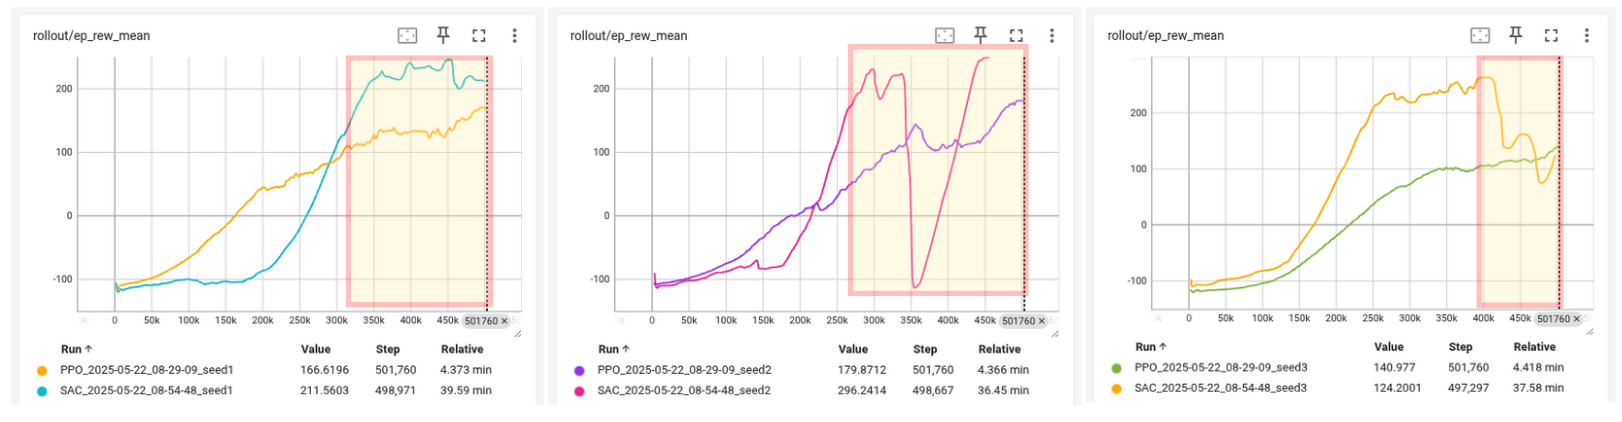

Since SAC has a high chance of exploring policy, there is a chance that the reward graph will fluctuate due to bad explore policy.

2. **SAC receives more rewards than PPO after some learning**

    - **Testing approach**: Use the average reward of the last 20,000 steps

    - **$H_0$**: $\mu_{\text{SAC}} = \mu_{\text{PPO}}$

    - **$H_1$**: $\mu_{\text{PPO}} < \mu_{\text{SAC}}$

From testing the difference in final reward means with z-test (n>=30), it was found that H0 was rejected. Therefore, it can be concluded that when the agent learns the policy for a period of time, SAC will make the agent receive more reward than PPO. At significance 0.05.

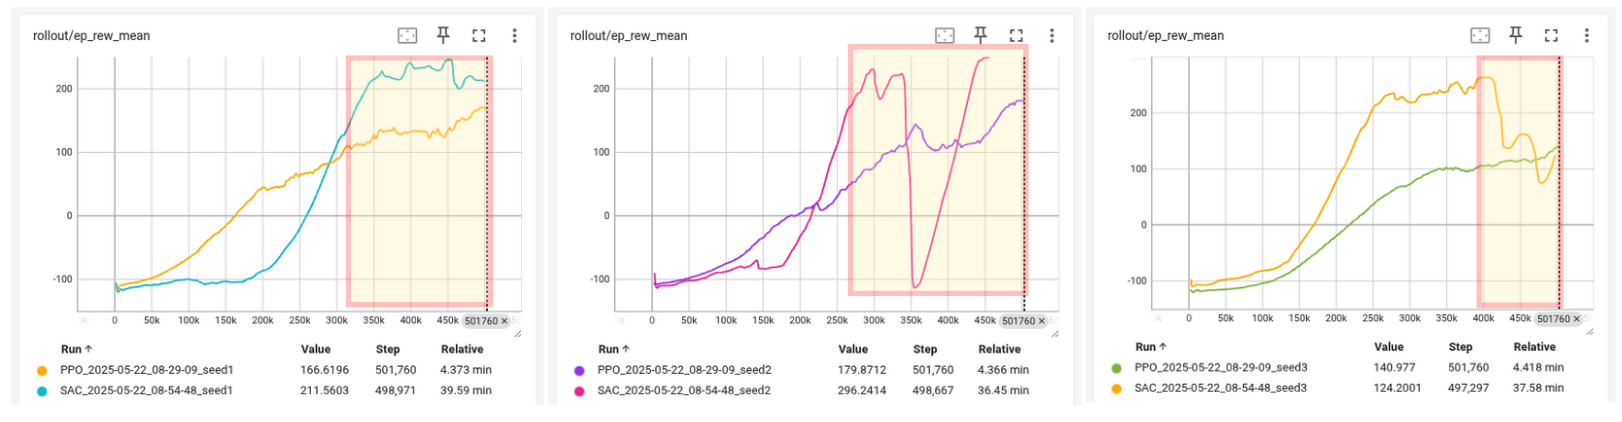

Although SAC generally provide higher rewards than PPO, sometimes poor SAC exploration policies at the end can cause rewards to fall.

3. **PPO makes the agent move more steadily than SAC**

    - **Testing approach**: Use the average of Spectral Flatness

    - **$H_0$**: $\mu_{\text{SF}}^{\text{PPO}} = \mu_{\text{SF}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{SF}}^{\text{PPO}} < \mu_{\text{SF}}^{\text{SAC}}$

From the test of the final reward mean difference using z-test (n>=30), it was found that H0 was rejected and it can be concluded that when the agent learns the policy for a period of time, SAC will make the agent receive more reward than PPO at a significance level of 0.05.

<div style="display: flex; justify-content: space-between; gap: 20px; width: 100%;">
  <div style="flex: 1; text-align: center;">
    <image src="PPO_best_episode_observation.png" controls style="width: 100%; max-width: 100%;"></image>
  </div>
  <div style="flex: 1; text-align: center;">
    <image src="PPO_best_episode_fft.png" controls style="width: 100%; max-width: 100%;"></image>
  </div>
</div>


<div style="display: flex; justify-content: space-between; gap: 20px; width: 100%;">
  <div style="flex: 1; text-align: center;">
    <image src="SAC_best_episode_observation.png" controls style="width: 100%; max-width: 100%;"></image>
  </div>
  <div style="flex: 1; text-align: center;">
    <image src="SAC_best_episode_fft.png" controls style="width: 100%; max-width: 100%;"></image>
  </div>
</div>

The reason why PPO makes the agent move as steady as SAC is that when observing the FFT of HIP1 PPO, it can be seen that all freqs have low power, meaning there is no walking pattern in HIP1. And in the position graph of all 4 joints of SAC, there is no pattern in the early period because it is adjusting and in the later period because it falls, so both are equally steady.

4. SAC finds more ways to move than PPO

    - **Testing approach** Compare the Pairwise Action Mean Square Error values ​​between different models in each possible state of both algorithms.

    - **$H_0$**: $\mu_{\text{MSE}}^{\text{PPO}} = \mu_{\text{MSE}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{MSE}}^{\text{PPO}} < \mu_{\text{MSE}}^{\text{SAC}}$

From the test of the Pairwise Action MSE mean difference using z-test (n>=30), it was found that H0 was rejected and it can be concluded that SAC found more ways to walk than PPO at the significance level of 0.05.

<div style="display: flex; justify-content: space-between; gap: 20px; width: 100%;">
  <div style="flex: 1; text-align: center;">
    <video src="PPO_best_episode_video.mp4" controls style="width: 100%; max-width: 100%;"></video>
    <p><em>PPO</em></p>
  </div>
  <div style="flex: 1; text-align: center;">
    <video src="SAC_best_episode_video.mp4" controls style="width: 100%; max-width: 100%;"></video>
    <p><em>SAC</em></p>
  </div>
</div>



Since SAC has more ways to move than PPO, SAC finds a way to move that seems faster and more natural than PPO, but with the risk that SAC has a higher chance of the agent falling than PPO.

5. **SAC reaches success points more often than PPO**

    - **Testing approach**: Compare the success rates of both algorithms

    - **$H_0$**: $p_{\text{SAC}} = p_{\text{PPO}}$

    - **$H_1$**: $p_{\text{PPO}} < p_{\text{SAC}}$

From the test of the difference in success rate proportion using z-test, it was found that H0 was accepted and it can be concluded that SAC reached the success point in the same number of rounds as PPO at the significance level of 0.05.

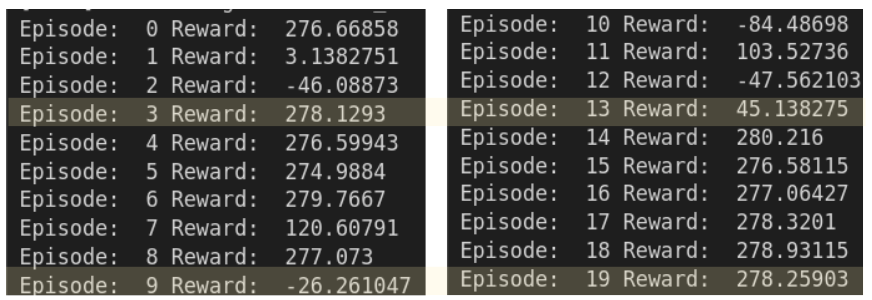

There are some seeds where some models cannot handle the situation in that seed.

6. **SAC has better robustness than PPO on new environment**

    - **Testing approach**: Use average reward on new environment

    - **$H_0$**: $\mu_{\text{Reward,new}}^{\text{PPO}} = \mu_{\text{Reward,new}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{Reward,new}}^{\text{PPO}} < \mu_{\text{Reward,new}}^{\text{SAC}}$

From the test of mean difference of reward with z-test (n>=30), it was found that H0 was accepted and it can be concluded that SAC has the same robustness as PPO when applied in a new environment at the significance level of 0.05.

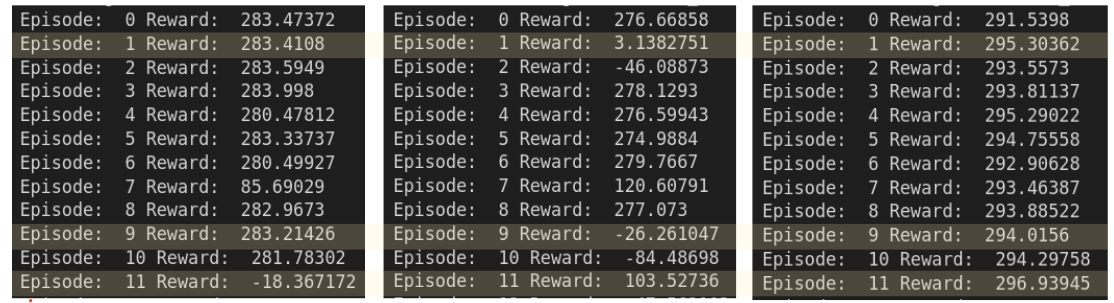

There are some models that can handle the situation in that seed (high reward) or cannot handle it at all (negative reward).

7. **PPO has higher reward variance than SAC**

    - **Testing approach**: Compare the mean of reward variance from multiple seed models

    - **$H_0$**: $\mu_{\text{Reward,Variance}}^{\text{PPO}} = \mu_{\text{Reward,Variance}}^{\text{SAC}}$

    - **$H_1$**: $\mu_{\text{Reward,Variance}}^{\text{PPO}} > \mu_{\text{Reward,Variance}}^{\text{SAC}}$

From the test of mean reward variance using t-test (n<30), it was found that H0 was accepted and it can be concluded that PPO has reward variance on test environment that is not different from SAC at the significance level of 0.05.

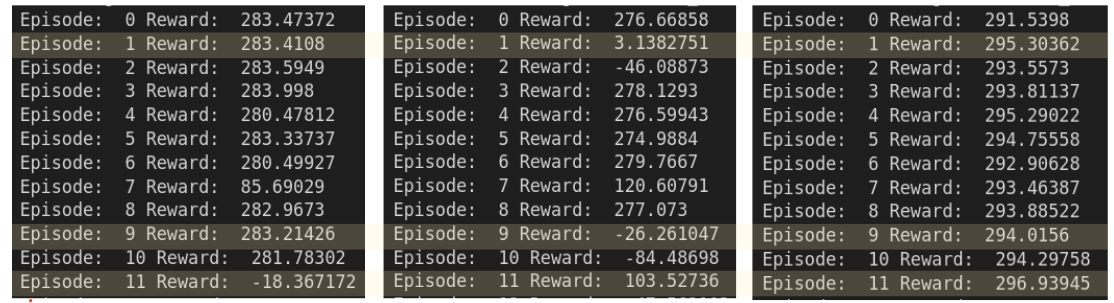

Reward Variance of each seed is very different because 1 model cannot learn a lot.

### <font color="yellow">**Conclusion**</font>

| Order | Hypothesis | Test results |
|-|---------------------------------------------------------------------------|----------------------------------------------------------------------------|
|1| PPO updates policy to its optimal value slower than SAC | PPO updates policy to its optimal value slower than SAC |
|2| When the agent has learned the policy for a while, SAC will make the agent receive more rewards than PPO | When the agent has learned the policy for a while, SAC will make the agent receive more rewards than PPO |
|3| PPO makes the agent move more steadily than SAC | PPO makes the agent move as steadily as SAC |
|4| SAC finds more ways to move than PPO | SAC finds more ways to move than PPO |
|5| SAC reaches success points more times than PPO | SAC reaches success points more times than PPO |
|6| SAC has better robustness than PPO when applied to new environments | SAC has the same robustness as PPO when applied to new environments |
|7| PPO has higher reward variance on test environments than SAC | PPO has the same reward variance on test environments as SAC |


From testing all hypotheses, it was found that the test results were consistent with the hypotheses set in hypotheses 1, 2, 4, and the hypotheses that did not match were hypotheses 3, 5, 6, 7. This may be because the training of 500,000 steps may be too little, the agent may learn more, and during the training period, there were too few models learning with each seed. And the model is biased too much towards any one seed, so further experiments may be developed to increase the number of training steps and increase the number of models to learn more seeds, including adjusting the hyperparameter to generalize to many seeds.